In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import under_sampling, over_sampling 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss


%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 27
random.seed(SEED)
np.random.seed(SEED)


In [2]:
p = Path.cwd()
data_path = p.parent.parent / 'data' / 'Raw' 
nfirs_path =  data_path / 'NFIRS_2009_2016_Combined_CensusBlock.csv'

cols_to_use = ['state','fdid','city','zip5','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)




svi2016_path = data_path.parent/ 'Master Project Data'  / 'SVI Tract Data.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     index_col=0,
                     dtype = svi_col_dtypes)




/Users/kelson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')


In [4]:
nfirs['GEOID'] =  nfirs['GEOID'].str.strip('.')
nfirs['GEOID'] = (nfirs['GEOID'].str[:-3].str.zfill(11))
nfirs['year'] = nfirs['inc_date'].dt.year.astype('str')
nfirs['GEOID'].str.len().value_counts()
# Add a year column to be used to groupby in addition to GEOID


11.0    1701002
Name: GEOID, dtype: int64

In [5]:
nfirs =  nfirs[~ nfirs['GEOID'].isna()]
nfirs['GEOID'].str[:2].unique()

array(['02', '01', '05', '04', '06', '08', '09', '11', '10', '12', '13',
       '15', '19', '16', '17', '18', '20', '21', '22', '25', '24', '23',
       '26', '27', '29', '28', '30', '37', '38', '31', '33', '34', '35',
       '32', '36', '39', '40', '41', '42', '44', '45', '46', '47', '48',
       '49', '51', '50', '53', '55', '54', '56'], dtype=object)

In [6]:
fires =  pd.crosstab(nfirs['GEOID'],nfirs['year'])
fires.head()

year,2009,2010,2011,2012,2013,2014,2015,2016
GEOID,,,,,,,,
01001020100,3,3,0,2,1,0,2,2
01001020200,4,1,5,1,2,1,2,1
01001020300,4,3,3,2,4,1,4,4
01001020400,8,1,4,0,3,1,4,1
01001020500,6,8,7,4,8,4,13,11


In [7]:
fires.describe(percentiles=[.75, .85, .9 ,.95, .99])

year,2009,2010,2011,2012,2013,2014,2015,2016
count,69677.000000,69677.000000,69677.000000,69677.000000,69677.000000,69677.000000,69677.000000,69677.000000
mean,2.853610,3.042152,2.786745,2.796690,2.946482,3.341992,3.289263,3.355741
std,4.120638,4.361317,3.981530,3.947692,4.026862,4.437227,4.309038,4.657069
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000
85%,6.000000,6.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000
90%,7.000000,7.000000,7.000000,7.000000,7.000000,8.000000,8.000000,8.000000
95%,10.000000,10.000000,9.000000,9.000000,10.000000,11.000000,10.000000,11.000000
99%,19.000000,19.000000,17.000000,18.000000,18.000000,20.000000,19.000000,20.000000


In [8]:
def plotFires(df):

    #g = sns.FacetGrid(nfirs,col = 'year' , row = 'GEOID', aspect=.25)
    #g.map(sns.distplot())
    figsize = (20, 16)
    cols = 4
    rows = 2
    f, axs = plt.subplots(cols,rows,figsize= figsize)



    cases = df.columns.to_list()
    for  case in enumerate(cases):
        ax = plt.subplot(cols,rows,case[0]+1)
        ax.set_title('All Fires {}'.format(str(case[1])) )
        plt.hist(df[case[1]],bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,20,40,80,100])
        #plt.hist(df[case[1]])





In [9]:
top10 = fires > fires.quantile(.9)


In [10]:
top10.sum() / top10.shape[0] * 100

year
2009    8.648478
2010    9.509594
2011    8.169123
2012    8.269587
2013    8.746071
2014    8.216485
2015    7.928011
2016    8.133243
dtype: float64

In [11]:
high2009 = fires[ fires['2009'] > 7] 

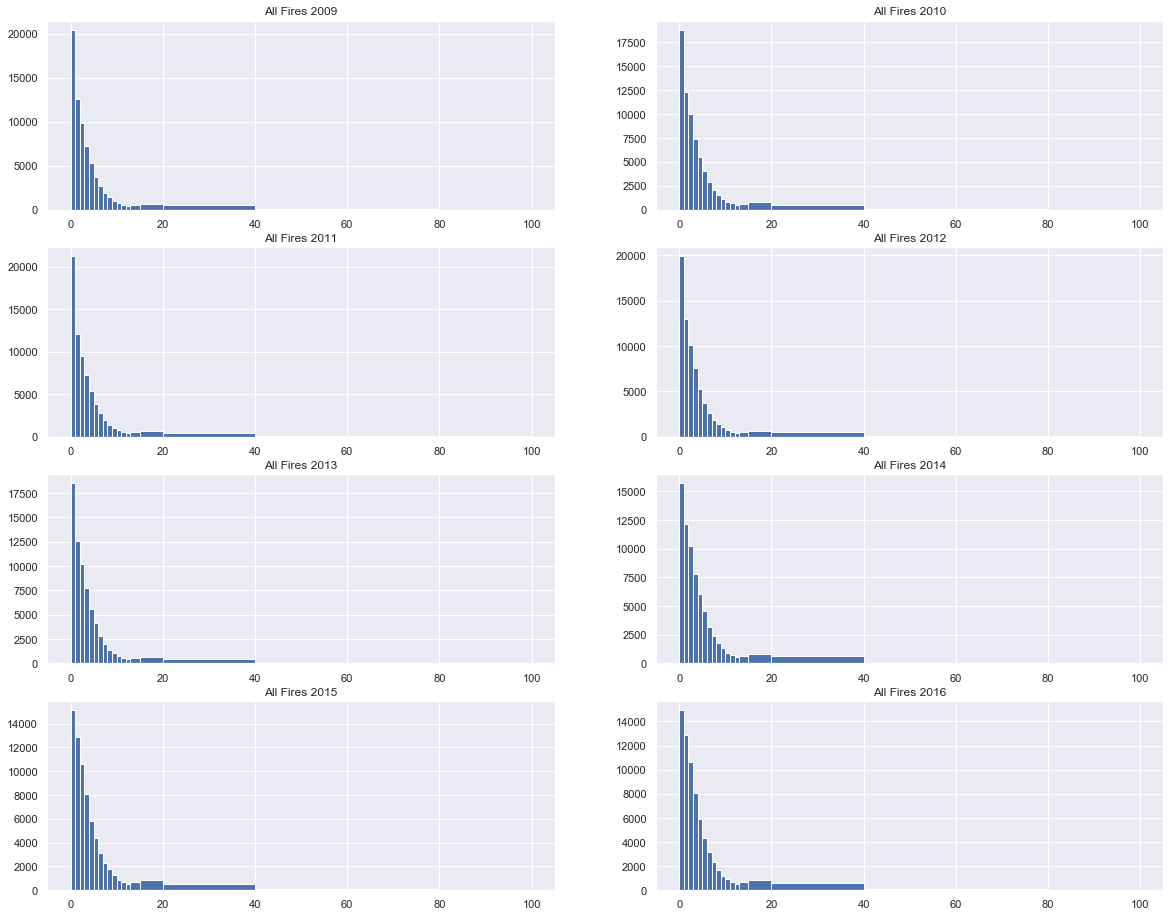

In [12]:
plotFires(fires)

In [13]:
def resample_df(X,y,upsample=True ,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    
    
    if upsample:      

        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0],
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      df_major_resampled.shape[0]))


    
    
    print(combined.columns)
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1 )
    return X_out , y_out

In [32]:
def train_model(fires,top10,nyears = 4,modeltype='LogisticRegression',resample = False, seed = SEED):
    from scipy.stats import zscore
    
    years = fires.columns
        
    start_pointer = 0
    end_pointer = nyears-1
    y_pointer = nyears
    
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced')
    
    elif modeltype =='SVM':
        from sklearn.svm import SVC
        model = SVC(
            gamma='auto',
            kernel='linear',
            class_weight = 'balanced',
            random_state=SEED)
        
    elif modeltype =='Bagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=0)

    elif modeltype == 'NN':
        model = MLPClassifier(hidden_layer_sizes=(nyears,nyears ),
                              activation='relu', 
                              solver='adam',
                              max_iter=500)
    

        
    while y_pointer < len(years):
        X_start, X_end = start_pointer, end_pointer
       
        X = fires.iloc[:,X_start:X_end].copy()
        
        L = X.shape[1] 
        X.columns = ['year-{}'.format(L - year) for year in range(L)]
        
        sm = np.sum(X, axis = 1 )
        mu = np.mean(X, axis = 1)
        md = np.median(X, axis = 1)
        mx = np.max(X, axis =1)
        X['Sum']  = sm
        X['Mean'] = mu
        X['Median'] =md
        X['Max']  = mx
       # X = X[['Max','Median','Sum']]
        y = top10.iloc[:,y_pointer]
        
    
    
        
        if resample:
            X,y = resample_df(X,y)
        
        #X = zscore(X.astype(float), axis=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )
        

        
        print('Predicting {}:'.format(years[y_pointer]) )
        model = model.fit(X_train,y_train)
        predictions = model.predict(X_test)

     
        print(classification_report(y_test,predictions))
        print(log_loss(y_test,predictions))
        
        start_pointer += 1
        end_pointer += 1
        y_pointer += 1
        
      
    feature_importance = {}
    for coef, feat in zip(abs(model.coef_[0]),X.columns.tolist()):
        feature_importance[feat] = coef
        
    return model, feature_importance,X_test,y_test
        
        








In [33]:
mdl,features,X_test,y_test =train_model(fires,top10,4,resample = True)

minor class 63583, major class 63583
Index(['year-3', 'year-2', 'year-1', 'Sum', 'Mean', 'Median', 'Max', 'Class'], dtype='object')
Predicting 2013:
              precision    recall  f1-score   support

       False       0.78      0.85      0.81     12710
        True       0.84      0.77      0.80     12724

    accuracy                           0.81     25434
   macro avg       0.81      0.81      0.81     25434
weighted avg       0.81      0.81      0.81     25434

6.669083482773534
minor class 63952, major class 63952
Index(['year-3', 'year-2', 'year-1', 'Sum', 'Mean', 'Median', 'Max', 'Class'], dtype='object')
Predicting 2014:
              precision    recall  f1-score   support

       False       0.79      0.85      0.82     12777
        True       0.84      0.77      0.80     12804

    accuracy                           0.81     25581
   macro avg       0.81      0.81      0.81     25581
weighted avg       0.81      0.81      0.81     25581

6.564600526530861
minor class 

In [34]:
mdl,features,X_test,y_test =train_model(fires,top10,4,resample = False)

Predicting 2013:
              precision    recall  f1-score   support

       False       0.97      0.85      0.91     12734
        True       0.32      0.75      0.45      1202

    accuracy                           0.84     13936
   macro avg       0.65      0.80      0.68     13936
weighted avg       0.92      0.84      0.87     13936

5.571521968279489
Predicting 2014:
              precision    recall  f1-score   support

       False       0.98      0.85      0.91     12814
        True       0.31      0.78      0.44      1122

    accuracy                           0.84     13936
   macro avg       0.64      0.81      0.68     13936
weighted avg       0.92      0.84      0.87     13936

5.440167035349873
Predicting 2015:
              precision    recall  f1-score   support

       False       0.97      0.86      0.91     12793
        True       0.32      0.75      0.45      1143

    accuracy                           0.85     13936
   macro avg       0.65      0.81      0.

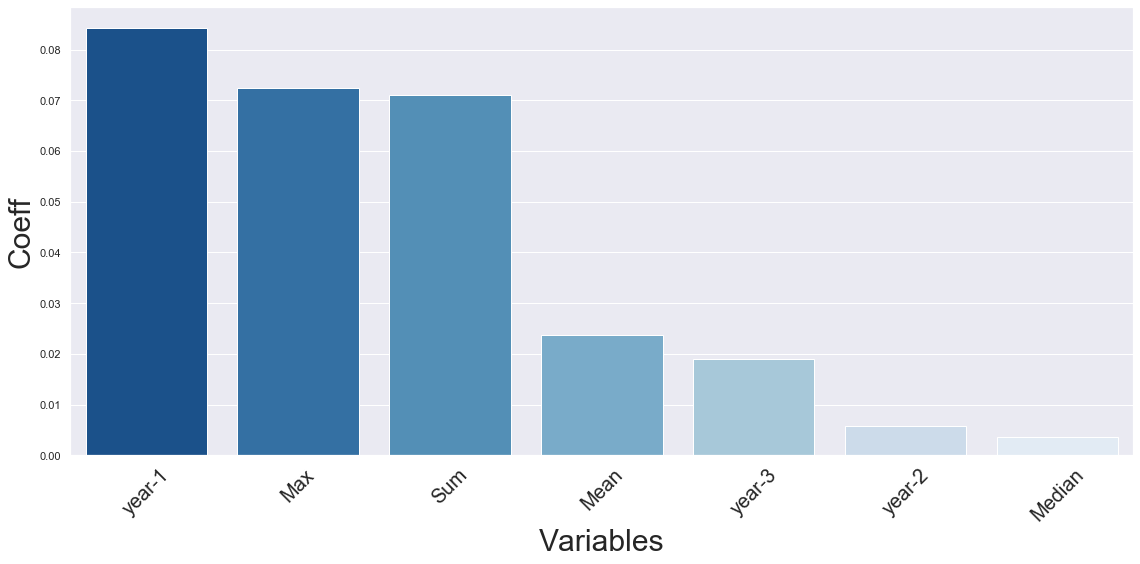

In [35]:
# let's now visualize this
data_to_plot = pd.DataFrame.from_dict(features,orient ='index').reset_index()
data_to_plot.columns = ['Variables','Importance Coefficients']
data_to_plot = data_to_plot.sort_values('Importance Coefficients', ascending=False )

plt.figure(figsize=(16, 8))
sns.barplot(
    x='Variables', y='Importance Coefficients',
    data=data_to_plot, palette='Blues_r')
plt.xticks(
    range(len(data_to_plot)),
    data_to_plot['Variables'], rotation='45', size=20)
plt.xlabel('Variables', fontsize=30)
plt.ylabel('Coeff', fontsize=30)
plt.tight_layout()
plt.show()

In [36]:
def process_data(X,y, test_size=0.2, seed=SEED):
    
    from scipy.stats import zscore
    
    
    X = np.log(X +1)
    y = np.log(y+1)
    
    print (X.shape)
   # rename features and add new features
    X.columns = ['year-{}'.format(year[0]+1) for year in enumerate(X.columns)]
    X.columns
    X['Sum'] = np.sum(X, axis = 1 )
    X['mean']= np.mean(X, axis = 1)
    X['median'] = np.median(x, axis = 1)
    
    
    X = zscore(X.astype(float), axis=0)
    
    
 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    return X_train, X_test, y_train, y_test

In [39]:
def plot_boundaries(X,y,model,n):
        
    from itertools import combinations
    n_elms = max(y.shape[0],1000) # only plot 1000 elements from each class
    
    n_cols = np.ceil(np.sqrt(n))
    n_rows = np.ceil(n / n_cols)

    names = X.columns
    combos = [c for c in combinations(range(X.shape[1]), 2) ]
    
    W = model.coef_[0]
        

    b = model.intercept_
    
    for c in enumerate(combos[:n]):
        x_idx = c[1][0]
        y_idx = c[1][1]
        plot_num = c[0]
            
            
        print('subplot{} {}: {}'.format(n_rows,n_cols,c[0]))
        plt.subplot(n_rows,n_cols,c[0]+1)
        plt.scatter(X.iloc[:n_elms, x_idx],
                    X.iloc[:n_elms, y_idx],
                    c=y[:n_elms], edgecolors='k',
                    alpha = .3, cmap=plt.cm.binary)
        
        ax = plt.gca()

        x_values = np.array(ax.get_xlim())
        y_values = -(b + np.dot(W[x_idx],x_values)) / W[y_idx]

        plt.plot(x_values, y_values )


        plt.xticks(())
        plt.xlabel(names[x_idx])
        plt.yticks(())
        plt.ylabel(names[y_idx])
    plt.show()

    
    
    
    
    
    
    

subplot4.0 4.0: 0
subplot4.0 4.0: 1
subplot4.0 4.0: 2
subplot4.0 4.0: 3
subplot4.0 4.0: 4
subplot4.0 4.0: 5
subplot4.0 4.0: 6
subplot4.0 4.0: 7
subplot4.0 4.0: 8
subplot4.0 4.0: 9
subplot4.0 4.0: 10
subplot4.0 4.0: 11
subplot4.0 4.0: 12
subplot4.0 4.0: 13
subplot4.0 4.0: 14
subplot4.0 4.0: 15


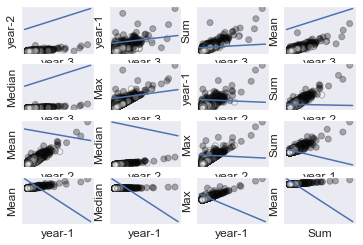

In [40]:
plot_boundaries(X_test,y_test,mdl,16)

In [41]:
x = np.random.multivariate_normal([0,0,0,0],np.identity(4),1000)
x[0:500,2] += 5
x[0:500,3] -= 5
x[:500,1] += -1
x[:500,0] -= 10
y = np.zeros([1000,])
y[:500] = 1 
from sklearn.linear_model import LogisticRegression

tmdl = LogisticRegression().fit(x,y)

x =pd.DataFrame(data = x,columns={'0','1','2','3'})

subplot3.0 4.0: 0
subplot3.0 4.0: 1
subplot3.0 4.0: 2
subplot3.0 4.0: 3
subplot3.0 4.0: 4
subplot3.0 4.0: 5


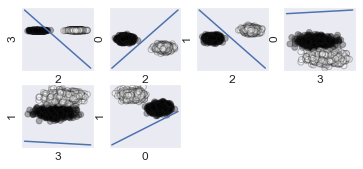

In [42]:
plot_boundaries(x,y,tmdl,12)

In [43]:
 from itertools import combinations
c= [c for c in combinations(range(5),2)]

for a in enumerate(c[:5]):
    print(a[0],a[1], a[1][0],a[1][1])

0 (0, 1) 0 1
1 (0, 2) 0 2
2 (0, 3) 0 3
3 (0, 4) 0 4
4 (1, 2) 1 2


In [24]:
def fit_clf_model(data, model='LogisticRegression', seed=0, verbose=True, variables=None):
    _allowed_models = ["LogisticRegression", "SVM", "Tree", "RandomForest"]
    assert model in _allowed_models, "Invalid model name entered. Allowed options: %s" % _allowed_models

    X_train, X_test, y_train, y_test = process_data(data, variables)

    if verbose:
        print('-' * 90)
        print('[PROGRESS] Training %s classifier...' % model)
    
    if model == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(
            solver='lbfgs', max_iter=1000,
            random_state=seed,
        ).fit(X_train, y_train)

    elif model == 'SVM':
        from sklearn.svm import SVC
        clf = SVC(
            gamma='auto',
            kernel='linear',
            random_state=seed,
        ).fit(X_train, y_train)
    
    elif model == 'Tree':
        from sklearn import tree
        clf = tree.DecisionTreeClassifier(
            random_state=seed,
        ).fit(X_train,y_train)
        
    elif model == 'RandomForest':
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
        ).fit(X_train,y_train)
    else:
        raise(NotImplemented)

    if verbose:
        print('[PROGRESS] ...done!')
        msg = "\n[INFO] Train accuracy: {0:.1f} %,    Test accuracy: {1:.1f} %".format(
            clf.score(X_train, y_train) * 100, clf.score(X_test, y_test) * 100)
        print(msg)
        print('-' * 90)
        print('\n')
    
    return clf

array([ 6., 30.,  5.])

array([5, 1, 6])